# Ionosphere Classification using Multilayer Perceptron

For these exercises we'll perform a binary classification on the Ionosphere Data Set available from the <a href = 'https://archive.ics.uci.edu/ml/datasets/Ionosphere'>UC Irvine Machine Learning Repository</a><br>
The goal is to classify radar returns from the ionosphere.

## Data Set Description
This radar data was collected by a system in Goose Bay, Labrador.  This
system consists of a phased array of 16 high-frequency antennas with a
total transmitted power on the order of 6.4 kilowatts.  See the paper
for more details.  The targets were free electrons in the ionosphere.
"Good" radar returns are those showing evidence of some type of structure 
in the ionosphere.  "Bad" returns are those that do not; their signals pass through the ionosphere.  

Received signals were processed using an autocorrelation function whose
arguments are the time of a pulse and the pulse number.  There were 17
pulse numbers for the Goose Bay system.  Instances in this databse are
described by 2 attributes per pulse number, corresponding to the complex
values returned by the function resulting from the complex electromagnetic
signal.

1. <b>Number of Instances:</b> 351

2. <b>Number of Attributes:</b> 34 plus the class attribute(Note that all 34 predictor attributes are continuous.)

3. <b>Attribute Information:</b>
    <ul>
    <li>All 34 are continuous, as described above</li>
    <li>The 35th attribute is either "good" or "bad" according to the definitione</li>
    <li>This is a binary classification task.</li>
    </ul>


## Loading the data

In [105]:
import numpy as np
import pandas as pd
import torch

In [106]:
df = pd.read_csv('data/ionosphere.data',header=None)

In [107]:
df

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,0,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,...,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307,g
347,1,0,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,...,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,g
348,1,0,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,...,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577,g
349,1,0,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,...,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,g


## Feature Engineering

## Dealing with categorical columns
Categorical data are variables that contain label values rather than numeric values. Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric.

Let's assign good and bad category with 1 and 0 respectively. Note that the 0 column acts like categorical feature.

In [108]:
df['target'] = df[34]
df = df.drop(34,axis = 1)

df[0] = df[0].astype('category')

In [109]:
df['target'] = df['target'].astype('category')
df['target'].value_counts()

g    225
b    126
Name: target, dtype: int64

In [110]:
df['target'] = df['target'].replace({'g':1, 'b' : 0})

## Removing Redundant Column
As you can see, the 1 column is 100% filled with 0. So this column doesn't give us any specific information.

In [111]:
df[1].value_counts()/ len(df) * 100

0    100.0
Name: 1, dtype: float64

In [112]:
df = df.drop(1,axis = 1)

## Train/Test Split

There are a number of ways to split the data into training and testing sets. The most common approach is to use some version of <b>random sampling</b>.

<b>1. Random sampling</b> : Completely random sampling is a straightforward strategy to implement and usually protects the process from being biased towards any characteristic of the data.

<b>2. Stratified random sample: </b>However random sampling approach can be problematic when the response is not evenly distributed across the outcome. A less risky splitting strategy would be to use a stratified random sample based on the outcome. For classification models, this is accomplished by selecting samples at random within each class. This approach ensures that the frequency distribution of the outcome is approximately equal within the training and test sets.

<b>3. Splitting using the temporal component:</b> Non-random sampling can also be used when there is a good reason. One such case would be when there is an important temporal aspect to the data. Here it may be prudent to use the most recent data as the test set.

Since the categories are not evenly distributed, we're going to use <b>Stratified Random Sampling</b> for this problem.

In [113]:
X = df.drop('target',axis = 1).to_numpy()
y = df['target'].to_numpy()

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Scaling the data

In [115]:
# from sklearn import preprocessing

# Scaler = preprocessing.MinMaxScaler()

# X_train_minmax = Scaler.fit_transform(X_train)

# X_train = Scaler.transform(X_train)
# X_test = Scaler.transform(X_test)

## Convert numpy arrays to tensors

In [116]:
y_col = ['target']
# Categorical Columns
cat_cols = [0]
# Continuous Columns
cont_cols = [x for x in range(2,34)]

In [117]:
test_cats = X_test[:, 0:1]
test_conts = X_test[:, 1:]
test_cats = torch.tensor(test_cats, dtype = torch.int64)
test_conts = torch.tensor(test_conts, dtype=torch.float)

test_conts

tensor([[ 0.6068, -0.0271,  0.6712,  ..., -0.0271,  0.5017,  0.0678],
        [ 0.6234, -0.0349,  0.5908,  ..., -0.0096,  0.6137, -0.0915],
        [ 1.0000,  0.0980,  1.0000,  ...,  0.5452, -0.4281,  0.4453],
        ...,
        [ 0.9954, -0.0589,  0.8524,  ..., -0.5449,  0.1864, -0.4530],
        [-1.0000,  1.0000, -1.0000,  ..., -0.3232,  0.1494,  1.0000],
        [ 0.6585,  0.4362,  0.4468,  ...,  0.7676, -0.1853,  0.7436]])

In [118]:
# Convert labels to a tensor
y_test_tensor = torch.tensor(y_test).flatten()

y_test_tensor[:10]

tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

## Set an embedding size
Since the data set contains categorical feature, we can use <a href="https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526">embdeddings</a> to deal with categorical features.

In [119]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1)]

## Define the model

Paramaters of our model : 
<ul>
    <li> <b>emb_szs:</b> each categorical variable size is paired with an embedding size</li>
    <li> <b>n_cont:</b> number of continuous variables</li>
    <li> <b>out_sz:</b> output size</li>
    <li> <b>layers:</b> layer sizes</li>
    <li> <b>p:</b> dropout probability for each layer</li>
</ul>

In [120]:
import torch.nn as nn
seed = 42
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5, activation_function = nn.ReLU(inplace=True)):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(activation_function)
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

## Part A : Model Architecture
The input layer has 33 neurons (1 categorical and 32 continuous features). And we also need 2 neurons for output layer since the problem is a binary classification.
There are two hidden layers with 200 and 100 neurons and the activation function is ReLU for each neuron in hidden layer. To avoid overfitting, we use Dropout.

## Train the model

Stochastic mini batch based: training data set are randomly divided to a certain number of subsets (mini-batches) then at each time a min-batch is chosen and applied.

In [121]:
def train(epochs, batch_size,model,criterion,optimizer) :
    training_losses = []
    valid_losses = []
    
    batches = len(X_train)/batch_size
    
    df_X_y = pd.DataFrame(X_train)
    df_X_y['target'] = pd.Series(y_train)
    
    # Shuffle the training set
    df_X_y = df_X_y.sample(frac = 1,random_state = 42)

    for i in range(epochs):
        # Test set
        with torch.no_grad():
            y_val = model(test_cats, test_conts)
            valid_loss = criterion(y_val, y_test_tensor).item()
            valid_losses.append(valid_loss)

        X_t = df_X_y.drop('target',axis = 1).values
        y_t = df_X_y['target'].values

        # Divide the training set into mini-batches and then feed to the network
        start = 0

        while start + batch_size < len(X_train) :        
            train_cats = torch.tensor(X_t[start:(start+batch_size), 0:1], dtype = torch.int64)
            train_conts = torch.tensor(X_t[start:(start+batch_size), 1:], dtype=torch.float)
            y_true = torch.tensor(y_t[start:(start+batch_size)]).flatten()

            y_pred = model(train_cats, train_conts)
            loss = criterion(y_pred, y_true)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            start = start + batch_size

            # Last Batch
            if start + batch_size >= len(X_train) :
                train_cats = torch.tensor(X_t[start:, 0:1], dtype = torch.int64)
                train_conts = torch.tensor(X_t[start:, 1:], dtype=torch.float)
                y_true = torch.tensor(y_t[start:]).flatten()

                y_pred = model(train_cats, train_conts)
                final_epoch_loss = criterion(y_pred, y_true)
                training_losses.append(final_epoch_loss.item())

                optimizer.zero_grad()
                final_epoch_loss.backward()
                optimizer.step()

        # To save screen space, every 25 epoch the training and test loss is shown
        if i%10 == 1:
            print(f'Epoch: {i:3}  Training Loss: {final_epoch_loss.item():10.8f}  Test Loss: {valid_loss:.8f}')


    print(f'Epoch: {epochs}  Training Loss: {final_epoch_loss.item():10.8f}  Test Loss: {valid_loss:.8f}')
    
    return training_losses,valid_losses

In [122]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import seaborn as sns
from sklearn.metrics import classification_report

def show_diagrams(training_losses,valid_losses,model) :
    
    plt.plot(training_losses)
    plt.plot(valid_losses)
    plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    with torch.no_grad():
        y_pred = model(test_cats, test_conts)

    y_val = []
    for i in range(len(y_pred)):
        y_val.append(y_pred[i].argmax().item())

    conf_mat = confusion_matrix(y_test.tolist(), y_val)
    sns.heatmap(conf_mat, annot=True, cmap='Blues')
    plt.title('Confusion Matrix')
    
    print(classification_report(y_test.tolist(), y_val, target_names=['bad','good']))

## Part B : Trying different neurons in hidden layers

### 1) 200 and 100 neurons in hidden layers (Best Model)

In [123]:
#Hidden Layer
hidden_layer = [200,100]
dropout_prob = 0.4
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=33, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

### Define loss function and optimizer

In [124]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [125]:
%%time
epochs = 20
batch_size = 8
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.62190312  Test Loss: 0.34160656
Epoch:  11  Training Loss: 0.39467219  Test Loss: 0.16658089
Epoch: 20  Training Loss: 0.02823020  Test Loss: 0.22117382
CPU times: user 1.43 s, sys: 793 ms, total: 2.23 s
Wall time: 1.55 s


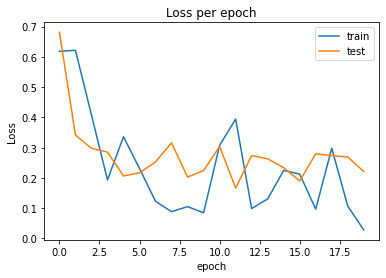

              precision    recall  f1-score   support

         bad       0.91      0.84      0.87        25
        good       0.92      0.96      0.94        46

    accuracy                           0.92        71
   macro avg       0.91      0.90      0.91        71
weighted avg       0.92      0.92      0.91        71



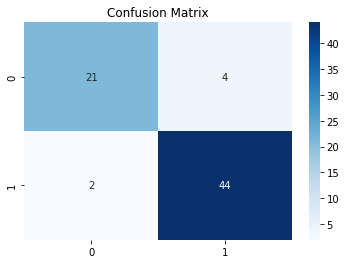

In [126]:
show_diagrams(training_losses,valid_losses,model)

### 2) 50 and 25 neurons in hidden layers

In [94]:
#Hidden Layer
hidden_layer = [50,25]
dropout_prob = 0.4
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 8
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.71714860  Test Loss: 0.51422668
Epoch:  11  Training Loss: 0.26386631  Test Loss: 0.34749949
Epoch:  21  Training Loss: 0.08324081  Test Loss: 0.39248392
Epoch:  31  Training Loss: 0.14792909  Test Loss: 0.23937041
Epoch:  41  Training Loss: 0.08432895  Test Loss: 0.25949612
Epoch:  51  Training Loss: 0.06243191  Test Loss: 0.22705834
Epoch:  61  Training Loss: 0.04060852  Test Loss: 0.26546901
Epoch:  71  Training Loss: 0.11490460  Test Loss: 0.25009045
Epoch:  81  Training Loss: 0.14397264  Test Loss: 0.31953943
Epoch:  91  Training Loss: 0.10785655  Test Loss: 0.33026770
Epoch: 100  Training Loss: 0.22531484  Test Loss: 0.14982951


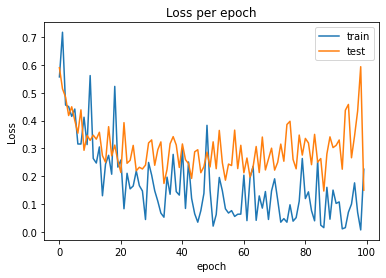

              precision    recall  f1-score   support

         bad       0.95      0.84      0.89        25
        good       0.92      0.98      0.95        46

    accuracy                           0.93        71
   macro avg       0.94      0.91      0.92        71
weighted avg       0.93      0.93      0.93        71



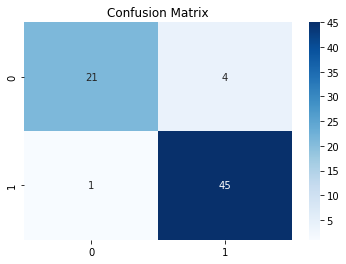

In [95]:
show_diagrams(training_losses,valid_losses,model)

### 3) 10 and 5 neurons in hidden layers


In [96]:
#Hidden Layer
hidden_layer = [10,5]
dropout_prob = 0.4
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 8
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.91334093  Test Loss: 0.63836235
Epoch:  11  Training Loss: 0.42331275  Test Loss: 0.46629602
Epoch:  21  Training Loss: 0.38164279  Test Loss: 0.39110014
Epoch:  31  Training Loss: 0.25546923  Test Loss: 0.42145112
Epoch:  41  Training Loss: 0.40848580  Test Loss: 0.42181981
Epoch:  51  Training Loss: 0.13651922  Test Loss: 0.31835487
Epoch:  61  Training Loss: 0.36991757  Test Loss: 0.26481104
Epoch:  71  Training Loss: 0.26827812  Test Loss: 0.32917529
Epoch:  81  Training Loss: 0.52536446  Test Loss: 0.30419219
Epoch:  91  Training Loss: 0.15110216  Test Loss: 0.26998088
Epoch: 100  Training Loss: 0.24640682  Test Loss: 0.30450398


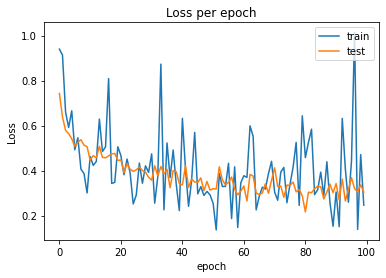

              precision    recall  f1-score   support

         bad       0.95      0.80      0.87        25
        good       0.90      0.98      0.94        46

    accuracy                           0.92        71
   macro avg       0.93      0.89      0.90        71
weighted avg       0.92      0.92      0.91        71



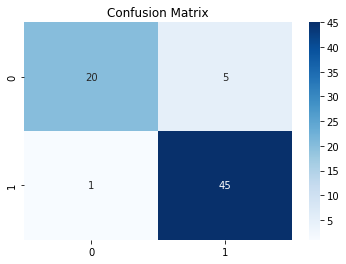

In [97]:
show_diagrams(training_losses,valid_losses,model)

## Part C : Trying different batch sizes
batch_size = 256 seems to be the best to one choose.

In [98]:
#Hidden Layer
hidden_layer = [200,100]
dropout_prob = 0.4
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=33, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

### 1) Batch size = 32

In [99]:
%%time
epochs = 100
batch_size = 32
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.32384023  Test Loss: 0.30881387
Epoch:  11  Training Loss: 0.04905418  Test Loss: 0.10539200
Epoch:  21  Training Loss: 0.06426143  Test Loss: 0.17545575
Epoch:  31  Training Loss: 0.01057324  Test Loss: 0.18864432
Epoch:  41  Training Loss: 0.00639555  Test Loss: 0.10483795
Epoch:  51  Training Loss: 0.01206115  Test Loss: 0.23777319
Epoch:  61  Training Loss: 0.00609993  Test Loss: 0.15787815
Epoch:  71  Training Loss: 0.00419355  Test Loss: 0.20059787
Epoch:  81  Training Loss: 0.00113583  Test Loss: 0.20238093
Epoch:  91  Training Loss: 0.00329989  Test Loss: 0.15064089
Epoch: 100  Training Loss: 0.00137709  Test Loss: 0.18729563
CPU times: user 2.56 s, sys: 1.65 s, total: 4.21 s
Wall time: 2.79 s


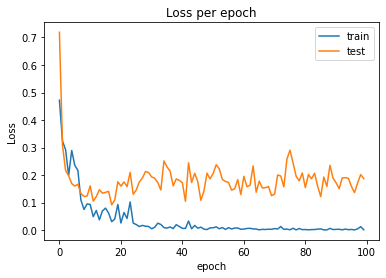

              precision    recall  f1-score   support

         bad       0.92      0.92      0.92        25
        good       0.96      0.96      0.96        46

    accuracy                           0.94        71
   macro avg       0.94      0.94      0.94        71
weighted avg       0.94      0.94      0.94        71



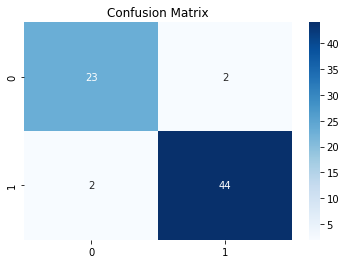

In [100]:
show_diagrams(training_losses,valid_losses,model)

### 2) Batch size = 64

In [101]:
%%time
#Hidden Layer
hidden_layer = [200,100]
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 64
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.35949650  Test Loss: 0.36219510
Epoch:  11  Training Loss: 0.10133048  Test Loss: 0.13561147
Epoch:  21  Training Loss: 0.06059061  Test Loss: 0.13949364
Epoch:  31  Training Loss: 0.04560452  Test Loss: 0.15789932
Epoch:  41  Training Loss: 0.01392691  Test Loss: 0.13849843
Epoch:  51  Training Loss: 0.00719124  Test Loss: 0.19749430
Epoch:  61  Training Loss: 0.01189901  Test Loss: 0.18426228
Epoch:  71  Training Loss: 0.01253448  Test Loss: 0.28613773
Epoch:  81  Training Loss: 0.01017532  Test Loss: 0.27035654
Epoch:  91  Training Loss: 0.01383042  Test Loss: 0.20547071
Epoch: 100  Training Loss: 0.00222983  Test Loss: 0.18137681
CPU times: user 1.57 s, sys: 996 ms, total: 2.57 s
Wall time: 1.7 s


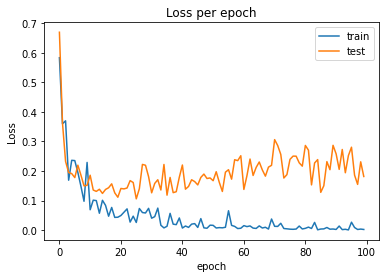

              precision    recall  f1-score   support

         bad       0.92      0.88      0.90        25
        good       0.94      0.96      0.95        46

    accuracy                           0.93        71
   macro avg       0.93      0.92      0.92        71
weighted avg       0.93      0.93      0.93        71



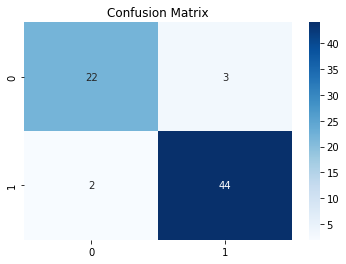

In [102]:
show_diagrams(training_losses,valid_losses,model)

### 3) Batch size = 256 (Best batch size among these 3)

In [103]:
%%time
#Hidden Layer
hidden_layer = [200,100]
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 256
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.48220897  Test Loss: 0.49733526
Epoch:  11  Training Loss: 0.12577476  Test Loss: 0.16659279
Epoch:  21  Training Loss: 0.07638016  Test Loss: 0.12460247
Epoch:  31  Training Loss: 0.02857061  Test Loss: 0.15179414
Epoch:  41  Training Loss: 0.04276483  Test Loss: 0.13513318
Epoch:  51  Training Loss: 0.02148081  Test Loss: 0.23879696
Epoch:  61  Training Loss: 0.01300868  Test Loss: 0.15446523
Epoch:  71  Training Loss: 0.00925980  Test Loss: 0.22571531
Epoch:  81  Training Loss: 0.00959276  Test Loss: 0.16765778
Epoch:  91  Training Loss: 0.00835790  Test Loss: 0.18334152
Epoch: 100  Training Loss: 0.00654143  Test Loss: 0.18724841
CPU times: user 749 ms, sys: 448 ms, total: 1.2 s
Wall time: 784 ms


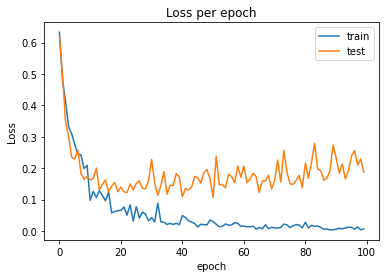

              precision    recall  f1-score   support

         bad       1.00      0.92      0.96        25
        good       0.96      1.00      0.98        46

    accuracy                           0.97        71
   macro avg       0.98      0.96      0.97        71
weighted avg       0.97      0.97      0.97        71



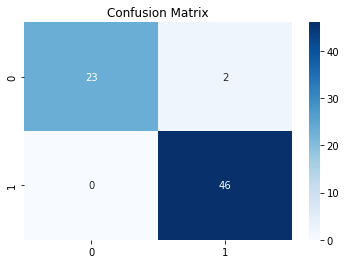

In [104]:
show_diagrams(training_losses,valid_losses,model)

## Part D : Trying different activation functions

### 1) ReLU

In [146]:
%%time
#Hidden Layer
hidden_layer = [200,100]
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4,activation_function = nn.ReLU(inplace=True))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 256
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.60060865  Test Loss: 0.49685556
Epoch:  11  Training Loss: 0.19695938  Test Loss: 0.20009656
Epoch:  21  Training Loss: 0.06015388  Test Loss: 0.19020692
Epoch:  31  Training Loss: 0.03675300  Test Loss: 0.14230473
Epoch:  41  Training Loss: 0.01881593  Test Loss: 0.16851123
Epoch:  51  Training Loss: 0.02255606  Test Loss: 0.16645643
Epoch:  61  Training Loss: 0.01423552  Test Loss: 0.10462214
Epoch:  71  Training Loss: 0.01087691  Test Loss: 0.10617708
Epoch:  81  Training Loss: 0.01476396  Test Loss: 0.20701312
Epoch:  91  Training Loss: 0.00730449  Test Loss: 0.12291852
Epoch: 100  Training Loss: 0.01103293  Test Loss: 0.24056059
CPU times: user 835 ms, sys: 479 ms, total: 1.31 s
Wall time: 876 ms


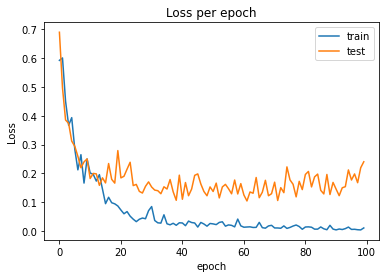

              precision    recall  f1-score   support

         bad       0.92      0.92      0.92        25
        good       0.96      0.96      0.96        46

    accuracy                           0.94        71
   macro avg       0.94      0.94      0.94        71
weighted avg       0.94      0.94      0.94        71



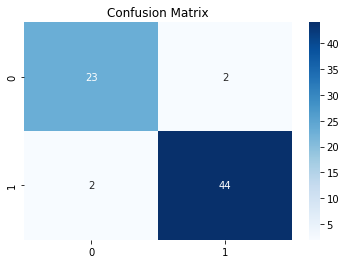

In [147]:
show_diagrams(training_losses,valid_losses,model)

### 2) Tanh

In [158]:
%%time
#Hidden Layer
hidden_layer = [200,100]
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4,activation_function = nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 256
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.55543119  Test Loss: 0.54752296
Epoch:  11  Training Loss: 0.31336850  Test Loss: 0.33012828
Epoch:  21  Training Loss: 0.18855424  Test Loss: 0.34263989
Epoch:  31  Training Loss: 0.18726522  Test Loss: 0.37712812
Epoch:  41  Training Loss: 0.07815560  Test Loss: 0.43446690
Epoch:  51  Training Loss: 0.06874162  Test Loss: 0.36460590
Epoch:  61  Training Loss: 0.08651375  Test Loss: 0.35500273
Epoch:  71  Training Loss: 0.04175164  Test Loss: 0.41723594
Epoch:  81  Training Loss: 0.02692732  Test Loss: 0.33744493
Epoch:  91  Training Loss: 0.04059235  Test Loss: 0.40713224
Epoch: 100  Training Loss: 0.08066297  Test Loss: 0.31222811
CPU times: user 882 ms, sys: 496 ms, total: 1.38 s
Wall time: 896 ms


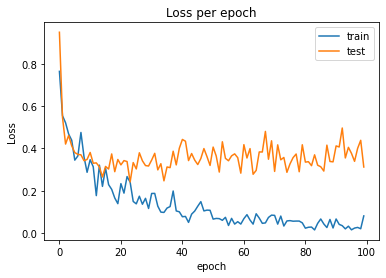

              precision    recall  f1-score   support

         bad       0.85      0.68      0.76        25
        good       0.84      0.93      0.89        46

    accuracy                           0.85        71
   macro avg       0.85      0.81      0.82        71
weighted avg       0.85      0.85      0.84        71



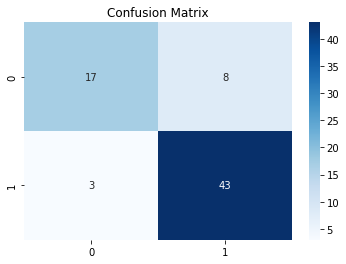

In [159]:
show_diagrams(training_losses,valid_losses,model)

### 3) Sigmoid

In [160]:
%%time
#Hidden Layer
hidden_layer = [200,100]
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4,activation_function = nn.Sigmoid())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 256
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.54054052  Test Loss: 0.49938577
Epoch:  11  Training Loss: 0.32349488  Test Loss: 0.29809812
Epoch:  21  Training Loss: 0.18222845  Test Loss: 0.26571375
Epoch:  31  Training Loss: 0.18089171  Test Loss: 0.35905984
Epoch:  41  Training Loss: 0.19640630  Test Loss: 0.43530467
Epoch:  51  Training Loss: 0.20177221  Test Loss: 0.36511594
Epoch:  61  Training Loss: 0.11907152  Test Loss: 0.39158005
Epoch:  71  Training Loss: 0.07222515  Test Loss: 0.47032288
Epoch:  81  Training Loss: 0.12212522  Test Loss: 0.41203019
Epoch:  91  Training Loss: 0.09719178  Test Loss: 0.47431779
Epoch: 100  Training Loss: 0.07224701  Test Loss: 0.38459691
CPU times: user 843 ms, sys: 477 ms, total: 1.32 s
Wall time: 878 ms


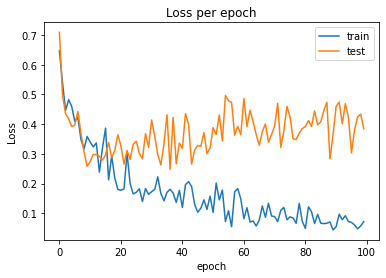

              precision    recall  f1-score   support

         bad       0.91      0.80      0.85        25
        good       0.90      0.96      0.93        46

    accuracy                           0.90        71
   macro avg       0.90      0.88      0.89        71
weighted avg       0.90      0.90      0.90        71



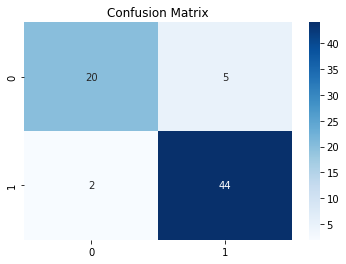

In [161]:
show_diagrams(training_losses,valid_losses,model)

## Part E : Trying different loss functions

### 1) Cross Entropy Loss (Best Loss Function)

## Part F : Trying different optimizer

### 1) Adam 
Adam optimizer seems to be working better than SGD.

In [148]:
%%time
#Hidden Layer
hidden_layer = [200,100]
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4,activation_function = nn.ReLU(inplace=True))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 256
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.44565174  Test Loss: 0.51320082
Epoch:  11  Training Loss: 0.14198481  Test Loss: 0.27689543
Epoch:  21  Training Loss: 0.04861319  Test Loss: 0.16317168
Epoch:  31  Training Loss: 0.03530030  Test Loss: 0.11977072
Epoch:  41  Training Loss: 0.01898927  Test Loss: 0.18118089
Epoch:  51  Training Loss: 0.01081735  Test Loss: 0.13353635
Epoch:  61  Training Loss: 0.01476086  Test Loss: 0.13677691
Epoch:  71  Training Loss: 0.00404578  Test Loss: 0.14645304
Epoch:  81  Training Loss: 0.00571570  Test Loss: 0.14776009
Epoch:  91  Training Loss: 0.00554995  Test Loss: 0.22054343
Epoch: 100  Training Loss: 0.00683897  Test Loss: 0.21742626
CPU times: user 801 ms, sys: 470 ms, total: 1.27 s
Wall time: 843 ms


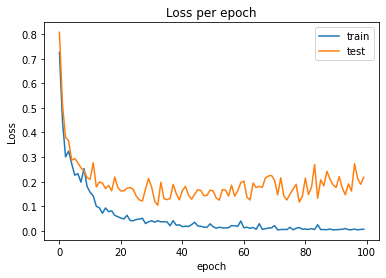

              precision    recall  f1-score   support

         bad       0.96      0.88      0.92        25
        good       0.94      0.98      0.96        46

    accuracy                           0.94        71
   macro avg       0.95      0.93      0.94        71
weighted avg       0.94      0.94      0.94        71



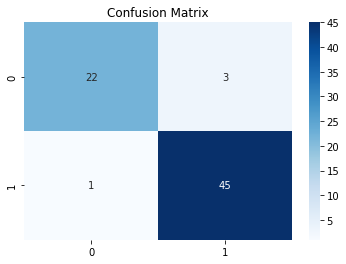

In [149]:
show_diagrams(training_losses,valid_losses,model)

### 2) SGD

In [150]:
%%time
#Hidden Layer
hidden_layer = [200,100]
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4,activation_function = nn.ReLU(inplace=True))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epochs = 100
batch_size = 256
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.82231981  Test Loss: 0.95999587
Epoch:  11  Training Loss: 0.46583188  Test Loss: 0.52111655
Epoch:  21  Training Loss: 0.36435744  Test Loss: 0.34419987
Epoch:  31  Training Loss: 0.27025244  Test Loss: 0.27912906
Epoch:  41  Training Loss: 0.18643481  Test Loss: 0.27150407
Epoch:  51  Training Loss: 0.24527447  Test Loss: 0.23730910
Epoch:  61  Training Loss: 0.13481633  Test Loss: 0.21255817
Epoch:  71  Training Loss: 0.17034173  Test Loss: 0.22187352
Epoch:  81  Training Loss: 0.08256936  Test Loss: 0.21713212
Epoch:  91  Training Loss: 0.06940372  Test Loss: 0.16129522
Epoch: 100  Training Loss: 0.10985083  Test Loss: 0.24950041
CPU times: user 710 ms, sys: 445 ms, total: 1.15 s
Wall time: 745 ms


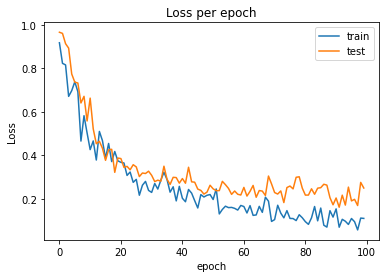

              precision    recall  f1-score   support

         bad       0.88      0.88      0.88        25
        good       0.93      0.93      0.93        46

    accuracy                           0.92        71
   macro avg       0.91      0.91      0.91        71
weighted avg       0.92      0.92      0.92        71



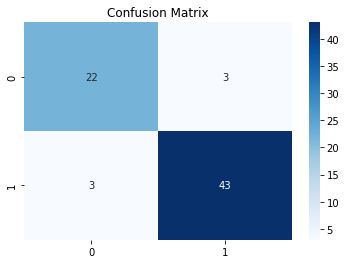

In [151]:
show_diagrams(training_losses,valid_losses,model)

## Part G : Trying different models

### Experiment 1 : Two Hidden Layers
The first and second hidden layer has 200 and 100 neurons respectively.

In [152]:
%%time
#Hidden Layer
hidden_layer = [200,100]
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4,activation_function = nn.ReLU(inplace=True))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 256
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.53356183  Test Loss: 0.52898955
Epoch:  11  Training Loss: 0.10218924  Test Loss: 0.17803220
Epoch:  21  Training Loss: 0.04265514  Test Loss: 0.15224102
Epoch:  31  Training Loss: 0.01977436  Test Loss: 0.14956880
Epoch:  41  Training Loss: 0.03608501  Test Loss: 0.18900728
Epoch:  51  Training Loss: 0.01910626  Test Loss: 0.17464301
Epoch:  61  Training Loss: 0.01985645  Test Loss: 0.17634441
Epoch:  71  Training Loss: 0.01201971  Test Loss: 0.16345198
Epoch:  81  Training Loss: 0.01338158  Test Loss: 0.19146638
Epoch:  91  Training Loss: 0.00607552  Test Loss: 0.17287949
Epoch: 100  Training Loss: 0.00726395  Test Loss: 0.15588455
CPU times: user 902 ms, sys: 507 ms, total: 1.41 s
Wall time: 948 ms


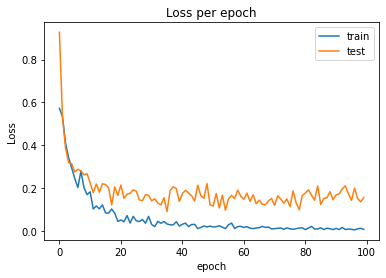

              precision    recall  f1-score   support

         bad       0.92      0.92      0.92        25
        good       0.96      0.96      0.96        46

    accuracy                           0.94        71
   macro avg       0.94      0.94      0.94        71
weighted avg       0.94      0.94      0.94        71



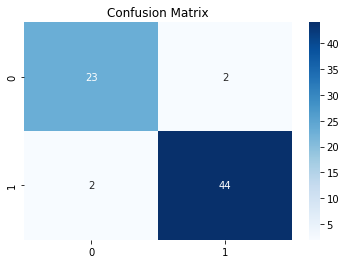

In [153]:
show_diagrams(training_losses,valid_losses,model)

### Experiment 2 : Three Hidden Layers
The first, second and third hidden layer has 200, 100 and 50 neurons respectively.

In [154]:
%%time
#Hidden Layer
hidden_layer = [200,100,50]
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4,activation_function = nn.ReLU(inplace=True))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 256
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.55154443  Test Loss: 0.73761421
Epoch:  11  Training Loss: 0.32727692  Test Loss: 0.33595634
Epoch:  21  Training Loss: 0.11399386  Test Loss: 0.26399460
Epoch:  31  Training Loss: 0.09092387  Test Loss: 0.25530928
Epoch:  41  Training Loss: 0.08642671  Test Loss: 0.18229865
Epoch:  51  Training Loss: 0.04091557  Test Loss: 0.16349091
Epoch:  61  Training Loss: 0.03778292  Test Loss: 0.22665599
Epoch:  71  Training Loss: 0.02927524  Test Loss: 0.14000237
Epoch:  81  Training Loss: 0.03671245  Test Loss: 0.15996775
Epoch:  91  Training Loss: 0.01751313  Test Loss: 0.20565061
Epoch: 100  Training Loss: 0.02489981  Test Loss: 0.19093679
CPU times: user 1.05 s, sys: 626 ms, total: 1.67 s
Wall time: 1.1 s


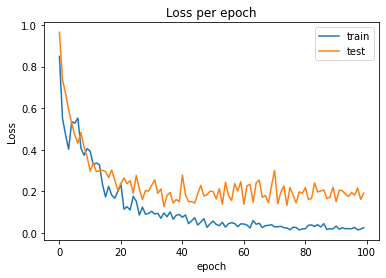

              precision    recall  f1-score   support

         bad       0.92      0.92      0.92        25
        good       0.96      0.96      0.96        46

    accuracy                           0.94        71
   macro avg       0.94      0.94      0.94        71
weighted avg       0.94      0.94      0.94        71



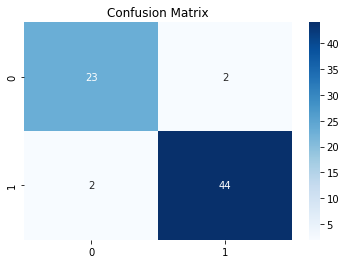

In [155]:
show_diagrams(training_losses,valid_losses,model)

### Experiment 3 : Four Hidden Layers
The first, second, third and fourth hidden layer has 1000,500, 250 and 125 neurons respectively.

In [156]:
%%time
#Hidden Layer
hidden_layer = [1000,500,250,125]
model = TabularModel(emb_szs = emb_szs, n_cont = len(cont_cols), out_sz = 2,
                     layers = hidden_layer , p = 0.4, activation_function = nn.ReLU(inplace=True))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 256
training_losses,valid_losses = train(epochs, batch_size,model,criterion,optimizer)

Epoch:   1  Training Loss: 0.36121634  Test Loss: 0.39482105
Epoch:  11  Training Loss: 0.04201045  Test Loss: 0.15041414
Epoch:  21  Training Loss: 0.02160096  Test Loss: 0.18810269
Epoch:  31  Training Loss: 0.01818898  Test Loss: 0.13590696
Epoch:  41  Training Loss: 0.00961359  Test Loss: 0.20043676
Epoch:  51  Training Loss: 0.00778492  Test Loss: 0.17540097
Epoch:  61  Training Loss: 0.00382747  Test Loss: 0.14473963
Epoch:  71  Training Loss: 0.00249039  Test Loss: 0.31123099
Epoch:  81  Training Loss: 0.00702321  Test Loss: 0.28855249
Epoch:  91  Training Loss: 0.00185994  Test Loss: 0.31827003
Epoch: 100  Training Loss: 0.00171150  Test Loss: 0.28393278
CPU times: user 4.98 s, sys: 1.68 s, total: 6.67 s
Wall time: 3.87 s


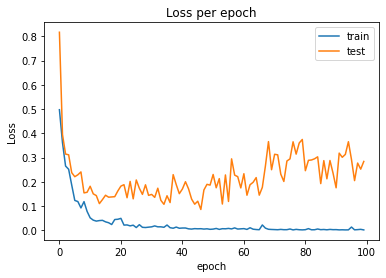

              precision    recall  f1-score   support

         bad       0.95      0.84      0.89        25
        good       0.92      0.98      0.95        46

    accuracy                           0.93        71
   macro avg       0.94      0.91      0.92        71
weighted avg       0.93      0.93      0.93        71



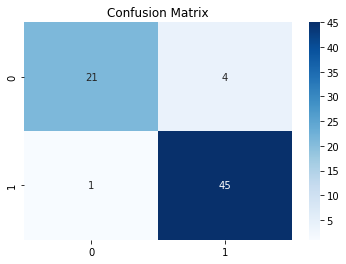

In [157]:
show_diagrams(training_losses,valid_losses,model)

## Part H : Conclusion

According to previous parts, these are the parameters :
<ul>
    <li>Batch size : 256</li>
    <li>Loss Function : CrossEntropyLoss</li>
    <li>Activation Function : ReLU</li>
    <li>Learning Rate : 0.001</li>
    <li>Four hidden layers with 1000, 500, 250 and 125 neurons.</li>
</ul>

We reached <b>96%</b> accuracy with these parameters.
Note that these parameters were found through experiments.

## Part I : What happens when labels are non uniformly distributed? How do you deal with it?

Suppose there are 50 data labeled A and 200 data labeled B. The model is more biased torwards class B after training because the model has seen more class B than A. So if our dataset is not uniformly distributed, we should try these methods :

### 1) Stratified sampling
This method is used to deal with imbalanced labels in this exercise.
<ul>
<li>It is done by dividing the population into subgroups or into strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the entire population.</li>

<li>Stratified sampling is different from simple random sampling, which involves the random selection of data from the entire population so that each possible sample is equally likely to occur.</li>

<li>A random sample is taken from each stratum in direct proportion to the size of the stratum compared to the population, so each possible sample is equally likely to occur.</li>
</ul>

### 2) Oversampling
Randomly duplicate examples in the minority class.

### 3) Undersampling
Randomly delete examples in the majority class.

### 4) Data augmentation
Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.